In [1]:
# pip install datasets umap-learn pycddlib dask dask-expr cvxopt
from datasets import load_dataset
import os
import importlib
import urllib.request
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.ipc as ipc
import dask.dataframe as dd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.spatial import ConvexHull

import polytope as pc
importlib.reload(pc)

from pypoman import compute_polytope_vertices
from pypoman import plot_polygon, project_polytope
from pypoman import compute_polytope_halfspaces

import cdd

from umap import UMAP

import manifold

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Create a dataframe containing the 16 reflexive 2D polytopes, see the paper [Unconditional Reflexive Polytopes](https://link.springer.com/article/10.1007/s00454-020-00199-8) of Florian Kohl, McCabe Olsen and Raman Sanyal.

In [3]:
polytope_data = [
    {"id": 1, "num_vertices": 3, "vertices": [[1, 0], [0, 1], [-1, -1]]},
    {"id": 2, "num_vertices": 4, "vertices": [[1, 0], [0, 1], [-1, 0], [0, -1]]},
    {"id": 3, "num_vertices": 4, "vertices": [[1, 0], [0, 1], [-1, -1], [-1, 1]]},
    {"id": 4, "num_vertices": 5, "vertices": [[2, -1], [1, 1], [-1, 1], [-2, -1], [0, -2]]},
    {"id": 5, "num_vertices": 6, "vertices": [[1, 0], [0, 1], [-1, 1], [-1, 0], [0, -1], [1, -1]]},
    {"id": 6, "num_vertices": 6, "vertices": [[2, 0], [0, 2], [-2, 0], [0, -2], [1, 1], [-1, -1]]},
    {"id": 7, "num_vertices": 6, "vertices": [[2, -1], [1, 1], [-1, 1], [-2, -1], [-1, -2], [1, -2]]},
    {"id": 8, "num_vertices": 7, "vertices": [[3, -1], [1, 2], [-1, 2], [-3, -1], [0, -3], [2, -2], [-2, -2]]},
    {"id": 9, "num_vertices": 8, "vertices": [[2, 1], [1, 2], [-1, 2], [-2, 1], [-2, -1], [-1, -2], [1, -2], [2, -1]]},
    {"id": 10, "num_vertices": 8, "vertices": [[3, -1], [1, 2], [-1, 2], [-3, -1], [-1, -3], [1, -3], [2, -2], [-2, -2]]},
    {"id": 11, "num_vertices": 8, "vertices": [[3, -1], [2, 1], [0, 3], [-2, 1], [-3, -1], [-2, -3], [0, -3], [2, -3]]},
    {"id": 12, "num_vertices": 8, "vertices": [[2, 2], [0, 3], [-2, 2], [-3, 0], [-2, -2], [0, -3], [2, -2], [3, 0]]},
    {"id": 13, "num_vertices": 10, "vertices": [[2, 2], [1, 3], [-1, 3], [-2, 2], [-3, 0], [-2, -2], [-1, -3], [1, -3], [2, -2], [3, 0]]},
    {"id": 14, "num_vertices": 12, "vertices": [[2, 2], [1, 3], [-1, 3], [-2, 2], [-3, 1], [-3, -1], [-2, -2], [-1, -3], [1, -3], [2, -2], [3, -1], [3, 1]]},
    {"id": 15, "num_vertices": 14, "vertices": [[3, -1], [2, 1], [0, 3], [-2, 1], [-3, -1], [-2, -3], [0, -3], [2, -3], [3, -2], [2, -1], [-1, -2], [-1, -1], [0, 1], [1, 1]]},
    {"id": 16, "num_vertices": 16, "vertices": [[3, 0], [2, 2], [0, 3], [-2, 2], [-3, 0], [-2, -2], [0, -3], [2, -2], [3, 0], [1, 3], [0, 1], [-1, 1], [1, -1], [-1, -2], [-3, 1], [2, 1]]}
]

df_poly2d = pd.DataFrame(polytope_data)
print(df_poly2d)

    id  num_vertices                                           vertices
0    1             3                         [[1, 0], [0, 1], [-1, -1]]
1    2             4                 [[1, 0], [0, 1], [-1, 0], [0, -1]]
2    3             4                [[1, 0], [0, 1], [-1, -1], [-1, 1]]
3    4             5      [[2, -1], [1, 1], [-1, 1], [-2, -1], [0, -2]]
4    5             6  [[1, 0], [0, 1], [-1, 1], [-1, 0], [0, -1], [1...
5    6             6  [[2, 0], [0, 2], [-2, 0], [0, -2], [1, 1], [-1...
6    7             6  [[2, -1], [1, 1], [-1, 1], [-2, -1], [-1, -2],...
7    8             7  [[3, -1], [1, 2], [-1, 2], [-3, -1], [0, -3], ...
8    9             8  [[2, 1], [1, 2], [-1, 2], [-2, 1], [-2, -1], [...
9   10             8  [[3, -1], [1, 2], [-1, 2], [-3, -1], [-1, -3],...
10  11             8  [[3, -1], [2, 1], [0, 3], [-2, 1], [-3, -1], [...
11  12             8  [[2, 2], [0, 3], [-2, 2], [-3, 0], [-2, -2], [...
12  13            10  [[2, 2], [1, 3], [-1, 3], [-2, 2], [-3, 0]

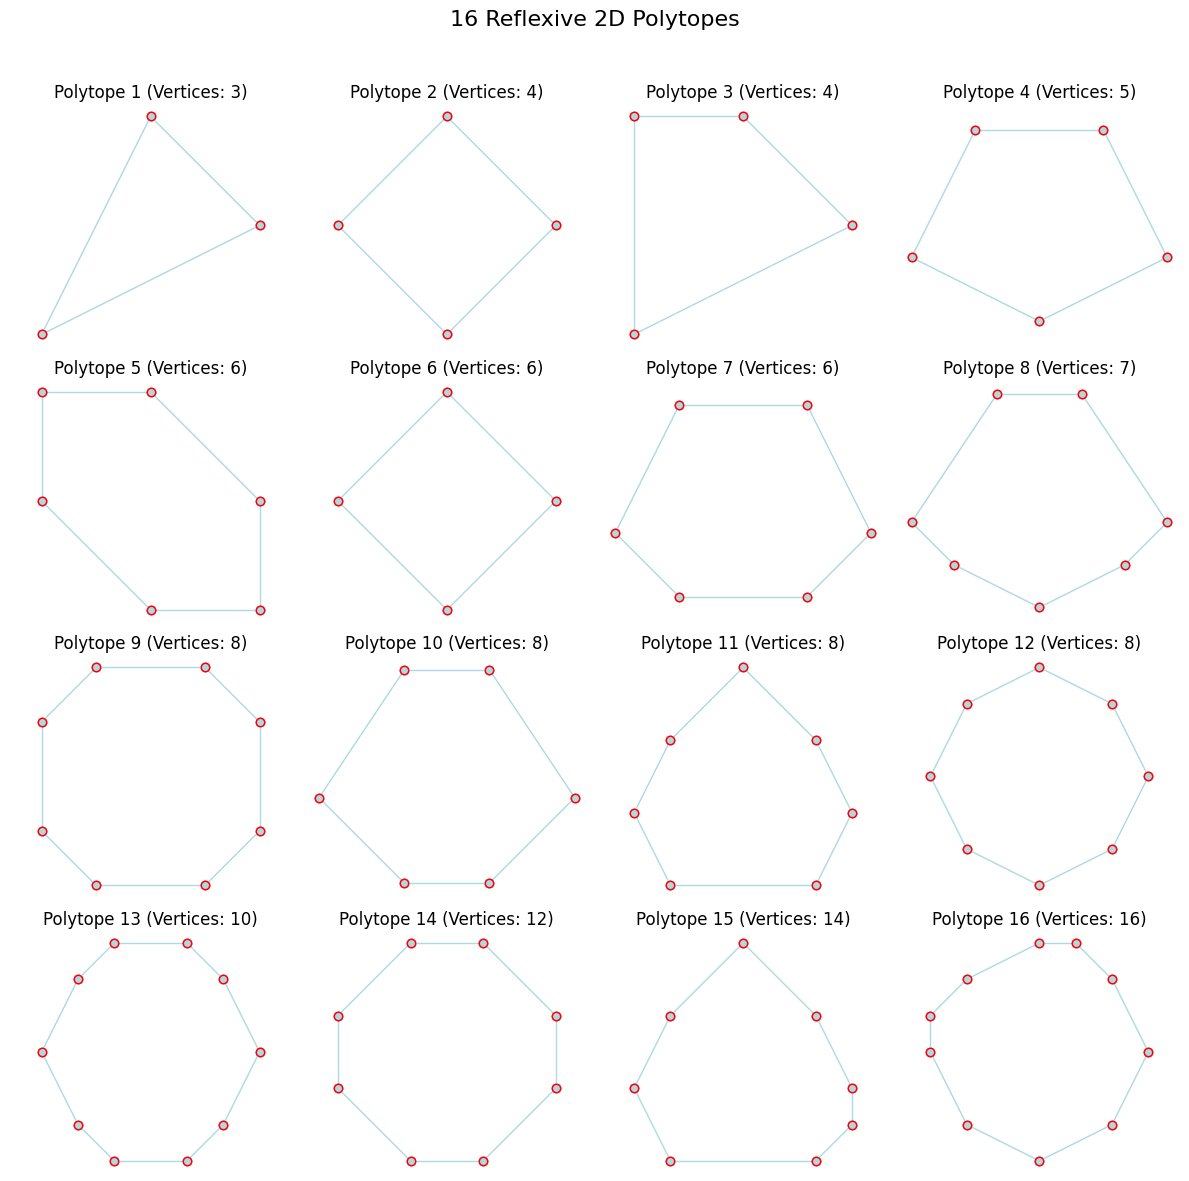

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("16 Reflexive 2D Polytopes", fontsize=16)

for i, (index, row) in enumerate(df_poly2d.iterrows()):
    ax = axes[i // 4, i % 4]  # Determine row and column index in 4x4 grid
    
    # Extract vertices and convert to NumPy array
    V = np.array(row['vertices'])
    
    # Compute convex hull using scipy's ConvexHull
    hull = ConvexHull(V)
    
    # Plot the polytope by drawing each hull edge
    for simplex in hull.simplices:
        ax.plot(V[simplex, 0], V[simplex, 1], 'o-', color="lightblue", markeredgecolor="red", linewidth=1)
    
    # Set axis limits
    min_V = np.min(V, axis=0)
    max_V = np.max(V, axis=0)
    min_x, min_y = min_V[0] - 1, min_V[1] - 1
    max_x, max_y = max_V[0] + 1, max_V[1] + 1
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    
    # Set titles and formatting
    ax.set_title(f"Polytope {row['id']} (Vertices: {row['num_vertices']})")
    ax.axis("equal")
    ax.axis("off")

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Download the [list of all 4319](http://hep.itp.tuwien.ac.at/%7Ekreuzer/pub/K3/RefPoly.d3) reflexive 3D polytopes from M. Kreuzer, H. Skarke (TU Wien), see [landing page](http://hep.itp.tuwien.ac.at/~kreuzer/CY/CYk3.html).

In [7]:
file_path = r"C:\Users\esultano\git\polytopes\data\tuwien\RefPoly.d3"
file_url = "http://hep.itp.tuwien.ac.at/~kreuzer/pub/K3/RefPoly.d3"

if not os.path.exists(file_path):
    print("File not found. Downloading now...")
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Download the file
    urllib.request.urlretrieve(file_url, file_path)
    print("Download completed.")
else:
    print("File already exists at the specified location.")

File already exists at the specified location.


In [8]:
data = {
    "dimension": [],
    "num_vertices": [],
    "m_lattice_points": [],
    "m_vertices": [],
    "n_lattice_points": [],
    "n_vertices": [],
    "picard_number": [],
    "correction": [],
    "vertices": []
}

with open(file_path, 'r') as file:
    while True:
        line = file.readline()
        if not line:
            break

        # Check for the start of a new polytope entry
        if line.startswith("3 "):  # Starts with "3" for dimension 3 polytopes
            # Parse the metadata line
            parts = line.split()
            dimension = int(parts[0])
            num_vertices = int(parts[1])
            m_lattice_points = int(parts[2][2:])  # Extract number after "M:"
            m_vertices = int(parts[3])
            n_lattice_points = int(parts[4][2:])  # Extract number after "N:"
            n_vertices = int(parts[5])
            picard_number = int(parts[6][4:])     # Extract number after "Pic:"
            correction = int(parts[7][4:])        # Extract number after "Cor:"

            # Store the metadata
            data["dimension"].append(dimension)
            data["num_vertices"].append(num_vertices)
            data["m_lattice_points"].append(m_lattice_points)
            data["m_vertices"].append(m_vertices)
            data["n_lattice_points"].append(n_lattice_points)
            data["n_vertices"].append(n_vertices)
            data["picard_number"].append(picard_number)
            data["correction"].append(correction)
            
            # Read the next 3 lines for vertex coordinates
            vertices = []
            for _ in range(3):
                vertex_line = file.readline().strip()
                # Convert vertex line to a list of integers
                vertex = list(map(int, vertex_line.split()))
                vertices.append(vertex)
            data["vertices"].append(vertices)

# Convert to DataFrame and check results
df_poly3d = pd.DataFrame(data)
print(df_poly3d['num_vertices'].value_counts())  # Check distribution
print(df_poly3d.head())

num_vertices
8     1051
7      964
9      801
6      611
10     405
5      250
11     143
4       48
12      37
13       8
14       1
Name: count, dtype: int64
   dimension  num_vertices  m_lattice_points  m_vertices  n_lattice_points  \
0          3             4                 5           4                35   
1          3             4                35           4                 5   
2          3             4                 6           4                30   
3          3             4                30           4                 6   
4          3             4                 9           4                21   

   n_vertices  picard_number  correction  \
0           4             19           0   
1           4              1           0   
2           4             18           2   
3           4              4           2   
4           4             16           6   

                                        vertices  
0  [[1, 0, 0, -1], [0, 1, 0, -1], [0, 0, 1, -1]]  
1  [

In [9]:
dataset = load_dataset("calabi-yau-data/polytopes-4d", cache_dir="C:/Users/esultano/git/polytopes/data/huggingface", split="full").shuffle(seed=42)
print("Verfügbare Aufteilungen:", dataset)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/237 [00:00<?, ?it/s]

Verfügbare Aufteilungen: Dataset({
    features: ['vertices', 'vertex_count', 'facet_count', 'point_count', 'dual_point_count', 'h11', 'h12', 'euler_characteristic'],
    num_rows: 473800776
})


In [10]:
percentage = 0.01
chunk_size = 10000
max_dfs = 3
sample_size = int(percentage * len(dataset))

dfs = []
for i in range(0, min(sample_size, max_dfs * chunk_size), chunk_size):
    chunk = dataset.select(range(i, min(i + chunk_size, sample_size)))
    dfs.append(chunk.to_pandas())

df_poly4d = pd.concat(dfs, ignore_index=True)

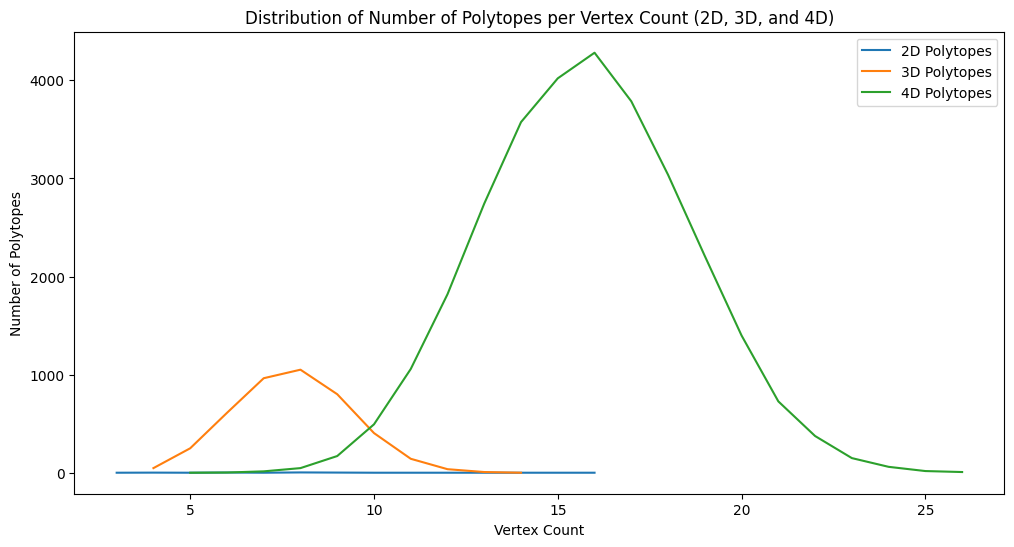

In [12]:
vertex_count_distribution_2d = df_poly2d['num_vertices'].value_counts().sort_index()
vertex_count_distribution_3d = df_poly3d['num_vertices'].value_counts().sort_index()
vertex_count_distribution_4d = df_poly4d['vertex_count'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

sns.lineplot(x=vertex_count_distribution_2d.index, y=vertex_count_distribution_2d.values, label="2D Polytopes")
sns.lineplot(x=vertex_count_distribution_3d.index, y=vertex_count_distribution_3d.values, label="3D Polytopes")
sns.lineplot(x=vertex_count_distribution_4d.index, y=vertex_count_distribution_4d.values, label="4D Polytopes")

plt.title("Distribution of Number of Polytopes per Vertex Count (2D, 3D, and 4D)")
plt.xlabel("Vertex Count")
plt.ylabel("Number of Polytopes")
plt.legend()
plt.show()